<a href="https://colab.research.google.com/github/Abigail6on/Apple-Health-Sleep-Analysis/blob/main/health_sleep_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep Data Analysis

This notebook performs an exploratory data analysis on sleep data exported from Apple Health.

# 1. Data Loading and Initial Inspection

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

# This is the most efficient way to parse the Apple Health XML
records = []
for event, element in ET.iterparse('/content/export.xml', events=("start",)):
    if element.tag == "Record":
        records.append(element.attrib)

df = pd.DataFrame(records)

# 2. Data Cleaning

Check missing values

In [ ]:
sleep_df.isna().sum()

,0
type,0
sourceName,0
creationDate,0
startDate,0
endDate,0
value,0


In [ ]:
sleep_df.dtypes

,0
type,object
sourceName,object
creationDate,object
startDate,"datetime64[ns, UTC-04:00]"
endDate,"datetime64[ns, UTC-04:00]"
value,object


# 3. Exploratory Data Analysis (EDA)

### Sleep Stage Analysis (2024 onward)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Filter for data from 2024 onwards and from Apple Watch
apple_watch_sleep_df = sleep_df[(sleep_df['startDate'].dt.year >= 2024) & (sleep_df['sourceName'] == 'Ellen’s Apple Watch')].copy()

# Display info of the filtered DataFrame
display(apple_watch_sleep_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16046 entries, 1014675 to 1031851
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   type          16046 non-null  object                   
 1   sourceName    16046 non-null  object                   
 2   creationDate  16046 non-null  object                   
 3   startDate     16046 non-null  datetime64[ns, UTC-04:00]
 4   endDate       16046 non-null  datetime64[ns, UTC-04:00]
 5   value         16046 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](2), object(4)
memory usage: 877.5+ KB


None

In [ ]:
# Calculate the duration of each sleep stage
apple_watch_sleep_df['duration'] = (apple_watch_sleep_df['endDate'] - apple_watch_sleep_df['startDate']).dt.total_seconds() / 60
apple_watch_sleep_df['duration_hour'] = apple_watch_sleep_df['duration'] / 60

# Group by sleep stage and calculate the average of the durations
sleep_stage_durations = apple_watch_sleep_df.groupby('value')['duration'].mean().sort_values(ascending=False)

display(sleep_stage_durations)

,duration
value,
HKCategoryValueSleepAnalysisInBed,39.944416
HKCategoryValueSleepAnalysisAsleepUnspecified,27.876344
HKCategoryValueSleepAnalysisAsleepCore,20.868298
HKCategoryValueSleepAnalysisAsleepREM,16.452214
HKCategoryValueSleepAnalysisAsleepDeep,9.366383
HKCategoryValueSleepAnalysisAwake,3.032725


In [ ]:
# Filter out 'HKCategoryValueSleepAnalysisInBed'
sleep_awake_df = apple_watch_sleep_df[apple_watch_sleep_df['value'] != 'HKCategoryValueSleepAnalysisInBed'].copy()

# Group by the date and sum the duration in hours for each night, excluding 'In Bed' time
daily_sleep_summary_excluding_inbed = sleep_awake_df.groupby(sleep_awake_df['startDate'].dt.date)['duration_hour'].sum()

# Convert the index to datetime for easier plotting later
daily_sleep_summary_excluding_inbed.index = pd.to_datetime(daily_sleep_summary_excluding_inbed.index)

display(daily_sleep_summary_excluding_inbed.head())

,duration_hour
startDate,
2024-02-17,9.708333
2024-02-18,7.375000
2024-02-19,8.591667
2024-02-20,8.725000
2024-02-21,8.291667


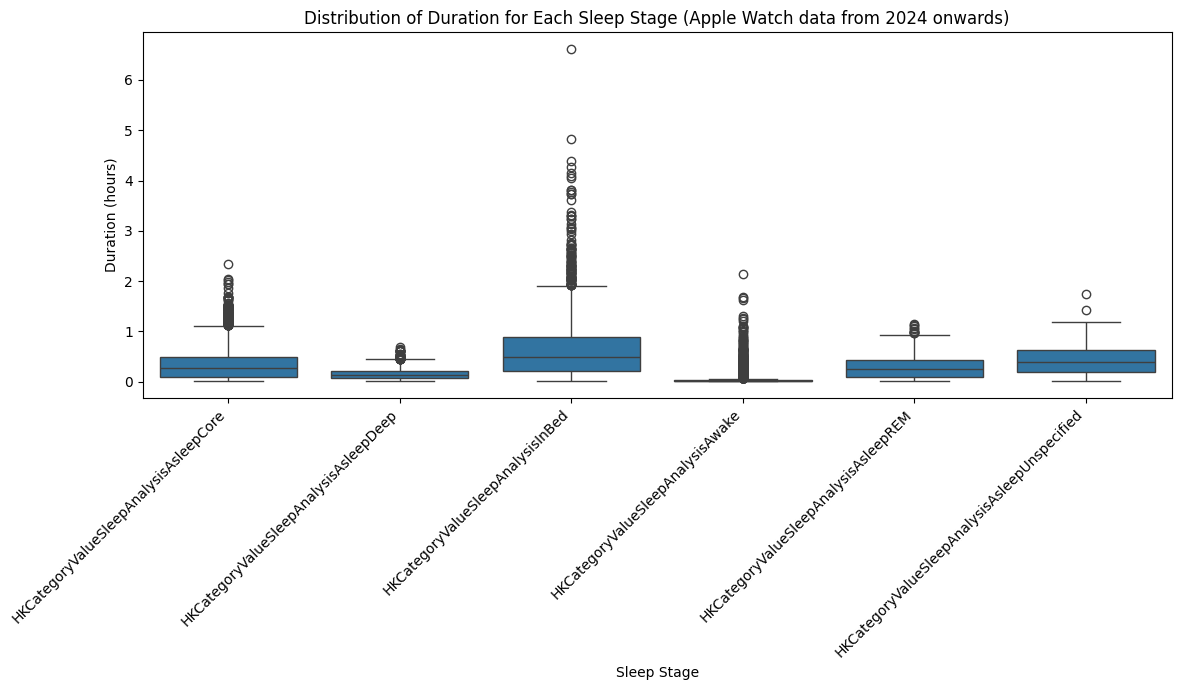

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='value', y='duration_hour', data=apple_watch_sleep_df)
plt.title('Distribution of Duration for Each Sleep Stage (Apple Watch data from 2024 onwards)')
plt.xlabel('Sleep Stage')
plt.ylabel('Duration (hours)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Handle outliers

In [ ]:
# Calculate Q1, Q3, and IQR for daily sleep duration
Q1 = daily_sleep_summary_excluding_inbed.quantile(0.25)
Q3 = daily_sleep_summary_excluding_inbed.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_sleep_summary_excluding_inbed[
    (daily_sleep_summary_excluding_inbed < lower_bound) | (daily_sleep_summary_excluding_inbed > upper_bound)]

print("Identified Outliers (Daily Sleep Duration):")
display(outliers)

# Create a new Series excluding outliers
daily_sleep_summary_no_outliers = daily_sleep_summary_excluding_inbed[
    (daily_sleep_summary_excluding_inbed >= lower_bound) & (daily_sleep_summary_excluding_inbed <= upper_bound)]

print("\nDaily Sleep Summary excluding Outliers (first 5 rows):")
display(daily_sleep_summary_no_outliers.head())

daily_sleep_summary_excluding_inbed = daily_sleep_summary_no_outliers

Identified Outliers (Daily Sleep Duration):


,duration_hour
startDate,
2024-04-13,11.341667
2024-04-28,11.291667
2024-06-14,0.441667
2024-06-17,0.475000
2024-07-11,0.508333
2024-07-19,0.633333
2024-07-31,0.516667
2024-08-02,1.075000
2024-09-07,0.583333



Daily Sleep Summary excluding Outliers (first 5 rows):


,duration_hour
startDate,
2024-02-17,9.708333
2024-02-18,7.375000
2024-02-19,8.591667
2024-02-20,8.725000
2024-02-21,8.291667


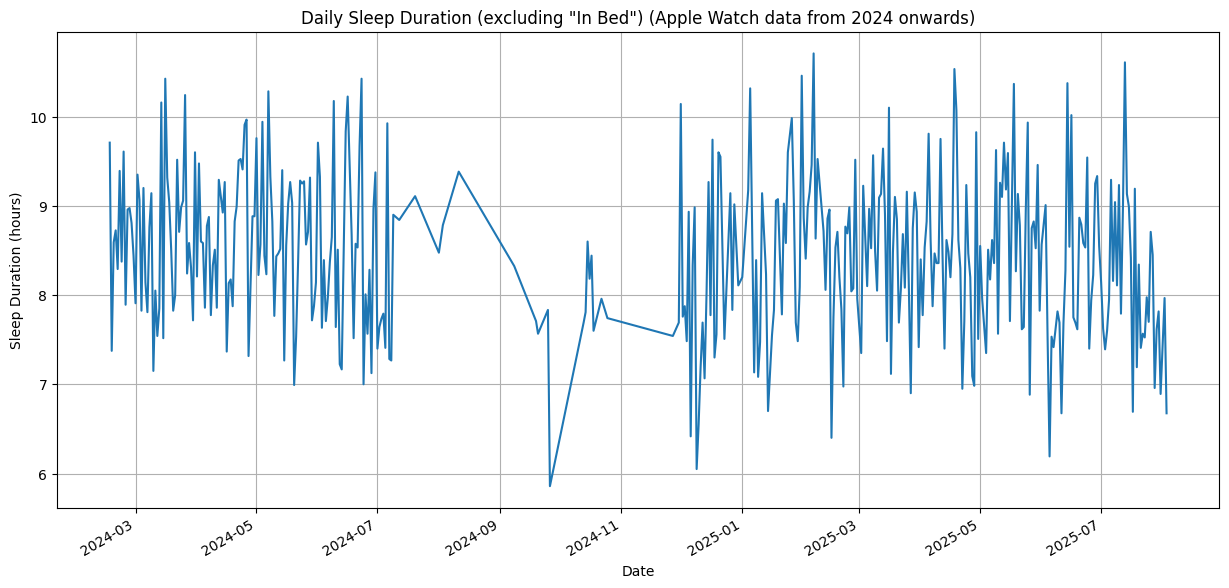

In [ ]:
plt.figure(figsize=(15, 7))
daily_sleep_summary_excluding_inbed.plot()
plt.title('Daily Sleep Duration (excluding "In Bed") (Apple Watch data from 2024 onwards)')
plt.xlabel('Date')
plt.ylabel('Sleep Duration (hours)')
plt.grid(True)
plt.show()

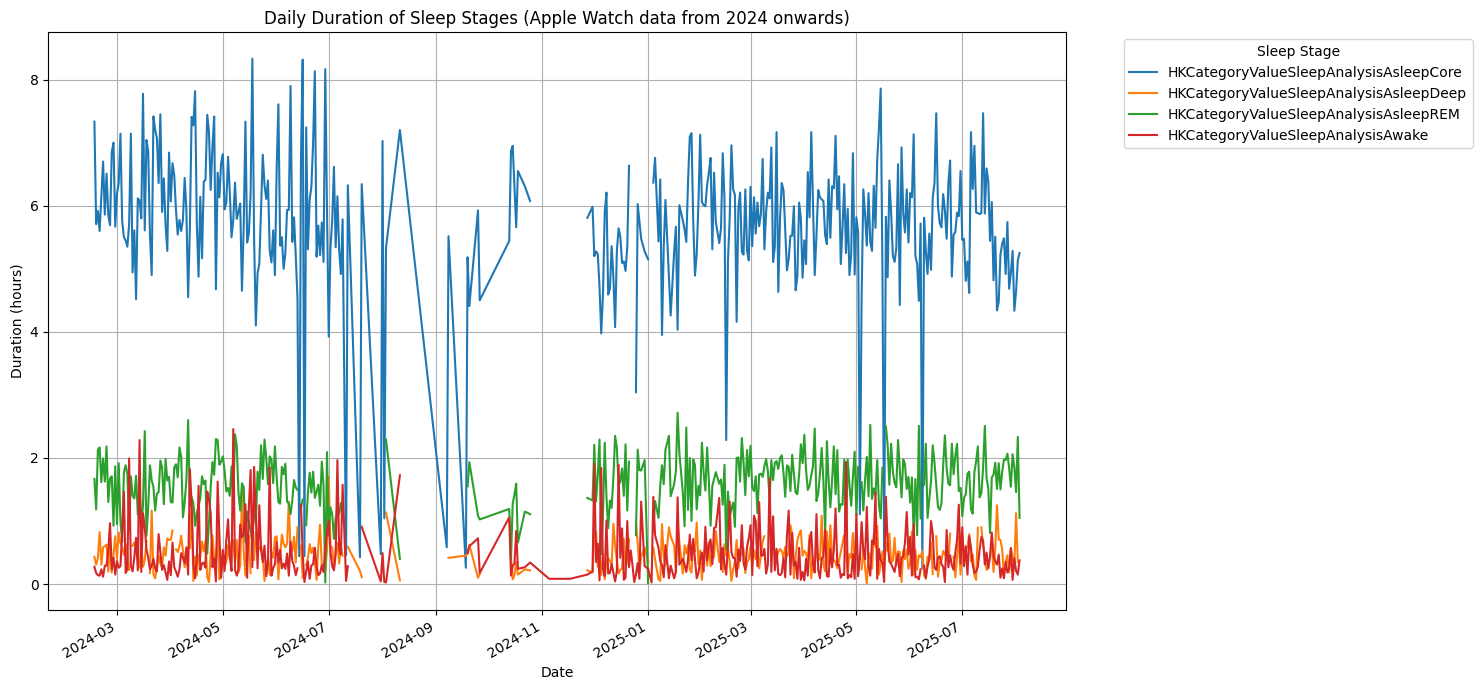

In [ ]:
# Define the sleep stages of interest
sleep_stages_of_interest = [
    'HKCategoryValueSleepAnalysisAsleepCore',
    'HKCategoryValueSleepAnalysisAsleepREM',
    'HKCategoryValueSleepAnalysisAsleepDeep',
    'HKCategoryValueSleepAnalysisAwake'
]

# Filter the DataFrame to include only the sleep stages of interest
filtered_sleep_stages_df = apple_watch_sleep_df[apple_watch_sleep_df['value'].isin(sleep_stages_of_interest)].copy()

# Group by date and sleep stage, and sum the duration in hours
daily_sleep_stage_duration = filtered_sleep_stages_df.groupby([filtered_sleep_stages_df['startDate'].dt.date, 'value'])['duration_hour'].sum().unstack()

# Convert the index to datetime
daily_sleep_stage_duration.index = pd.to_datetime(daily_sleep_stage_duration.index)

# Plot the daily duration of each sleep stage
plt.figure(figsize=(15, 7))
daily_sleep_stage_duration.plot(ax=plt.gca())
plt.title('Daily Duration of Sleep Stages (Apple Watch data from 2024 onwards)')
plt.xlabel('Date')
plt.ylabel('Duration (hours)')
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

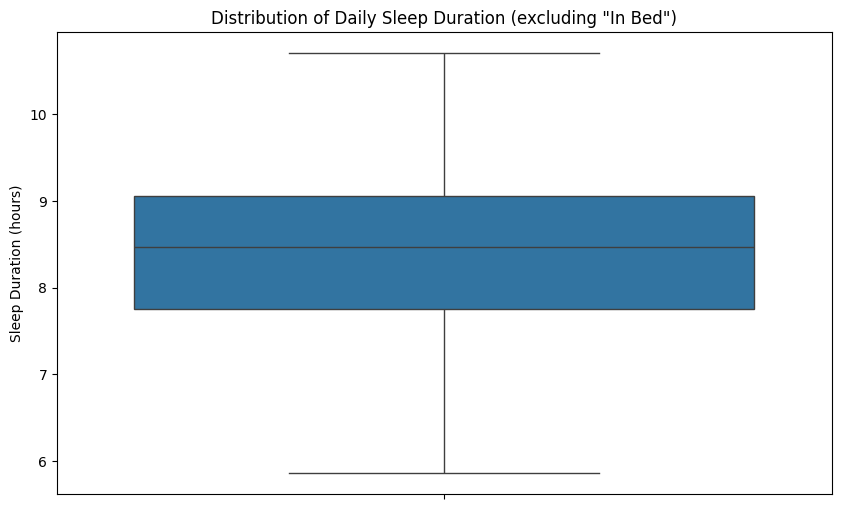

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=daily_sleep_summary_excluding_inbed)
plt.title('Distribution of Daily Sleep Duration (excluding "In Bed")')
plt.ylabel('Sleep Duration (hours)')
plt.show()

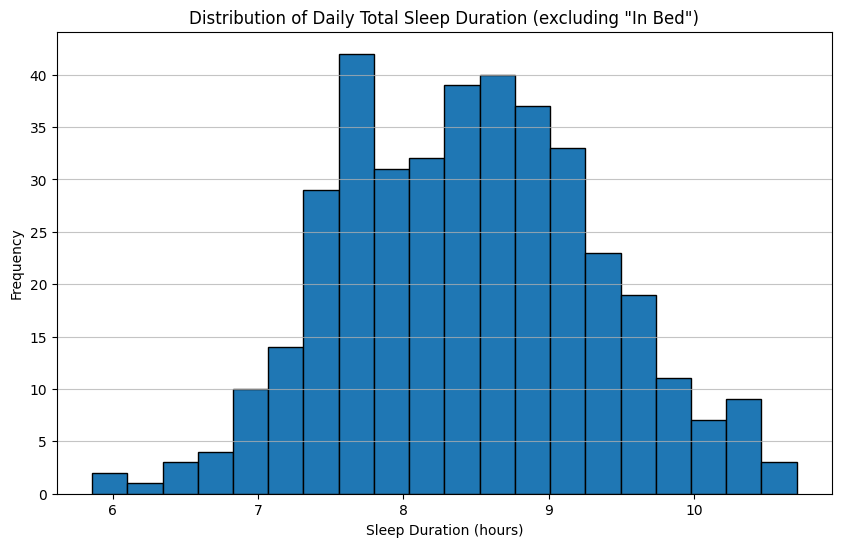

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(daily_sleep_summary_excluding_inbed, bins=20, edgecolor='black')
plt.title('Distribution of Daily Total Sleep Duration (excluding "In Bed")')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
sleep_df.head()
sleep_df['sourceName'].unique()

array(['Clock', 'Kim’ iPhone', 'Ellen’ iPhone', 'Ellen’s Apple\xa0Watch'],
      dtype=object)

In [ ]:
# Filter the DataFrame to show only records from 'Ellen’s Apple Watch'
apple_watch_all_sleep_df = sleep_df[sleep_df['sourceName'] == 'Ellen’s Apple\xa0Watch'].copy()

# Display info of the filtered DataFrame
display(apple_watch_all_sleep_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16046 entries, 1014675 to 1031851
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   type          16046 non-null  object                   
 1   sourceName    16046 non-null  object                   
 2   creationDate  16046 non-null  object                   
 3   startDate     16046 non-null  datetime64[ns, UTC-04:00]
 4   endDate       16046 non-null  datetime64[ns, UTC-04:00]
 5   value         16046 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](2), object(4)
memory usage: 877.5+ KB


None

In [ ]:
# Analyze the distribution of sleep stages in the full Apple Watch data
apple_watch_sleep_stage_counts = apple_watch_all_sleep_df['value'].value_counts()
display(apple_watch_sleep_stage_counts)

,count
value,
HKCategoryValueSleepAnalysisAsleepCore,6621
HKCategoryValueSleepAnalysisAwake,3942
HKCategoryValueSleepAnalysisAsleepREM,2281
HKCategoryValueSleepAnalysisInBed,1934
HKCategoryValueSleepAnalysisAsleepDeep,1175
HKCategoryValueSleepAnalysisAsleepUnspecified,93


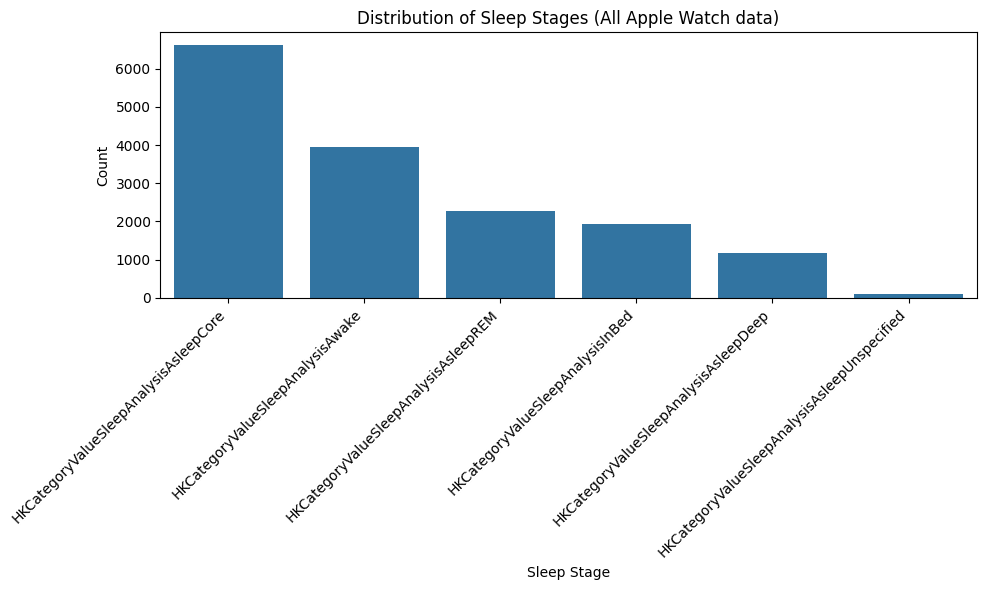

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=apple_watch_sleep_stage_counts.index, y=apple_watch_sleep_stage_counts.values)
plt.title('Distribution of Sleep Stages (All Apple Watch data)')
plt.xlabel('Sleep Stage')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Extract month and year
apple_watch_sleep_df['year_month'] = apple_watch_sleep_df['startDate'].dt.to_period('M')

# Group by month and year and calculate the average duration for each sleep stage
monthly_sleep_stage_duration = apple_watch_sleep_df.groupby(['year_month', 'value'])['duration_hour'].mean().unstack()

display(monthly_sleep_stage_duration.head())

/tmp/ipython-input-4234311064.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  apple_watch_sleep_df['year_month'] = apple_watch_sleep_df['startDate'].dt.to_period('M')


value,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,HKCategoryValueSleepAnalysisInBed
year_month,,,,,,
2024-02,0.331216,0.134574,0.268699,NaN,0.028333,0.713562
2024-03,0.328222,0.160322,0.242908,NaN,0.046353,0.638168
2024-04,0.347243,0.147396,0.270905,NaN,0.053246,0.699648
2024-05,0.326222,0.150000,0.332207,NaN,0.064427,0.652719
2024-06,0.347624,0.144967,0.265850,NaN,0.037427,0.725185


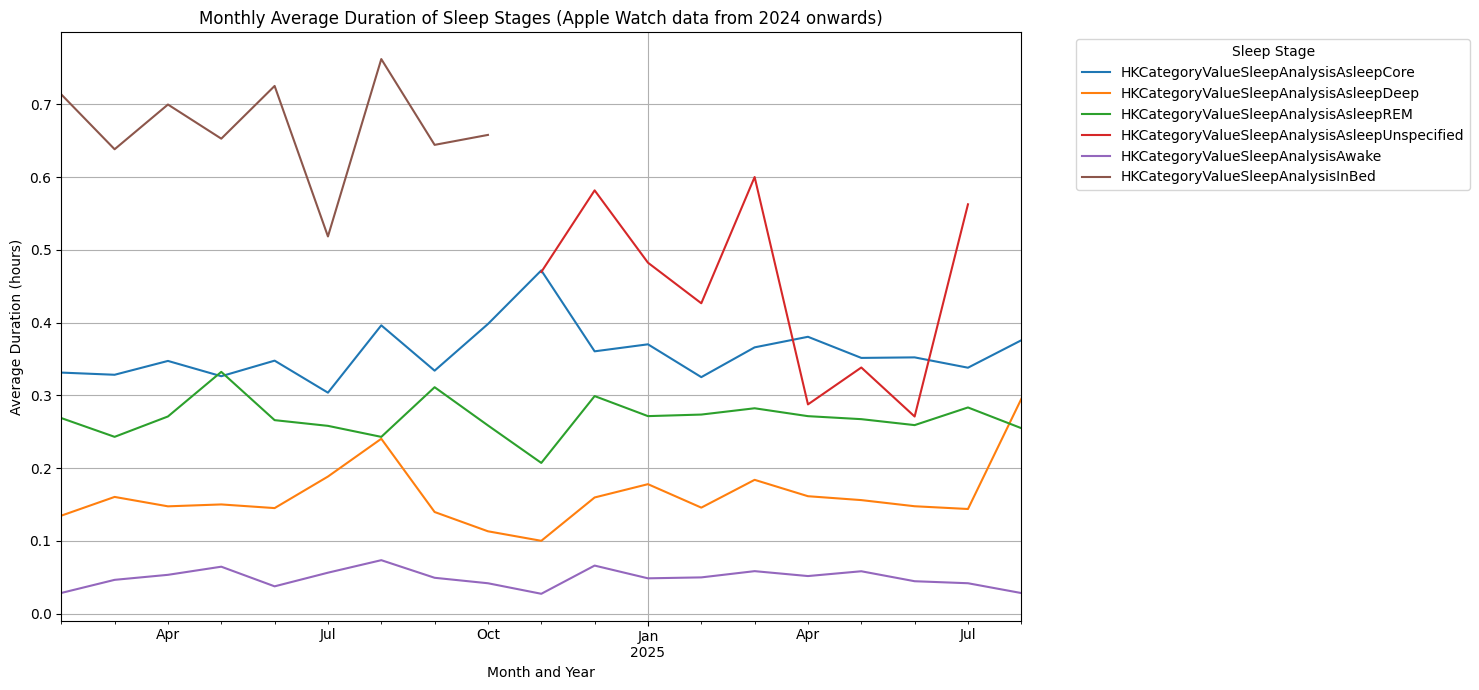

In [ ]:
# Plot the monthly average duration of each sleep stage
plt.figure(figsize=(15, 7))
monthly_sleep_stage_duration.plot(ax=plt.gca())
plt.title('Monthly Average Duration of Sleep Stages (Apple Watch data from 2024 onwards)')
plt.xlabel('Month and Year')
plt.ylabel('Average Duration (hours)')
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyse sleeping time accoding to different seasons

In [ ]:
# Define summer and winter months
summer_months = [6, 7, 8]  # June, July, August
winter_months = [12, 1, 2]  # December, January, February

# Extract the month from the startDate
apple_watch_sleep_df['month'] = apple_watch_sleep_df['startDate'].dt.month

# Categorize each record into 'Summer', 'Winter', or 'Other'
def categorize_season(month):
    if month in summer_months:
        return 'Summer'
    elif month in winter_months:
        return 'Winter'
    else:
        return 'Other'

apple_watch_sleep_df['season'] = apple_watch_sleep_df['month'].apply(categorize_season)

# Filter out the 'Other' season for comparison
seasonal_sleep_df = apple_watch_sleep_df[apple_watch_sleep_df['season'].isin(['Summer', 'Winter'])].copy()

# Group by season and sleep stage and calculate the average duration
seasonal_sleep_stage_duration = seasonal_sleep_df.groupby(['season', 'value'])['duration_hour'].mean().unstack()

display(seasonal_sleep_stage_duration)

value,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,HKCategoryValueSleepAnalysisInBed
season,,,,,,
Summer,0.342981,0.153923,0.267565,0.368056,0.043866,0.662434
Winter,0.346756,0.156083,0.279253,0.499583,0.050158,0.713562


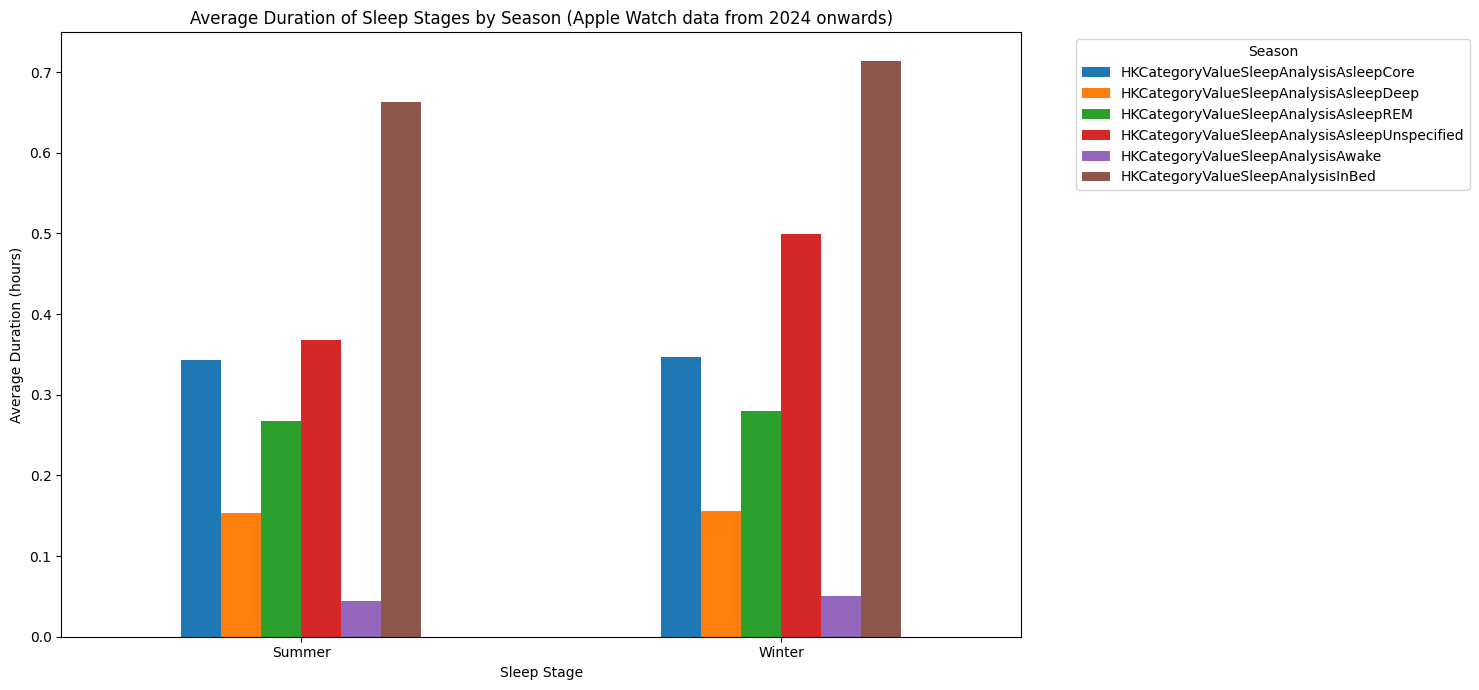

In [ ]:
seasonal_sleep_stage_duration.plot(kind='bar', figsize=(15, 7))
plt.title('Average Duration of Sleep Stages by Season (Apple Watch data from 2024 onwards)')
plt.xlabel('Sleep Stage')
plt.ylabel('Average Duration (hours)')
plt.xticks(rotation=0)
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Filter for 'In Bed' records to get approximate bedtime and wake-up times
in_bed_df = apple_watch_sleep_df[apple_watch_sleep_df['value'] == 'HKCategoryValueSleepAnalysisInBed'].copy()

# Extract the time component from startDate (bedtime) and endDate (wake-up time)
in_bed_df['bedtime'] = in_bed_df['startDate'].dt.time
in_bed_df['wake_up_time'] = in_bed_df['endDate'].dt.time

# Display the first few rows with the new time columns
display(in_bed_df.head())

,type,sourceName,creationDate,startDate,endDate,value,duration,duration_hour,year_month,month,season,bedtime,wake_up_time
1014677,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 00:08:28-04:00,2024-02-17 00:45:28-04:00,HKCategoryValueSleepAnalysisInBed,37.0,0.616667,2024-02,2,Winter,00:08:28,00:45:28
1014680,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 00:46:28-04:00,2024-02-17 01:09:58-04:00,HKCategoryValueSleepAnalysisInBed,23.5,0.391667,2024-02,2,Winter,00:46:28,01:09:58
1014686,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 01:10:28-04:00,2024-02-17 02:35:28-04:00,HKCategoryValueSleepAnalysisInBed,85.0,1.416667,2024-02,2,Winter,01:10:28,02:35:28
1014689,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 02:36:58-04:00,2024-02-17 03:06:58-04:00,HKCategoryValueSleepAnalysisInBed,30.0,0.500000,2024-02,2,Winter,02:36:58,03:06:58
1014692,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 03:08:58-04:00,2024-02-17 03:22:58-04:00,HKCategoryValueSleepAnalysisInBed,14.0,0.233333,2024-02,2,Winter,03:08:58,03:22:58


In [ ]:
# Convert time objects to a format that allows for easier calculation of statistics if needed later
# For now, we can focus on visualizing the distribution of times directly.

# Display descriptive statistics for bedtime and wake-up time (Note: direct statistical calculation on time objects is limited)
# We can visualize the distribution to understand consistency.

print("Bedtime Distribution (first 5):")
display(in_bed_df['bedtime'].head())

print("\nWake-up Time Distribution (first 5):")
display(in_bed_df['wake_up_time'].head())

# To get a sense of the range, we can sort the times
print("\nEarliest Bedtime:")
display(in_bed_df['bedtime'].min())

print("\nLatest Bedtime:")
display(in_bed_df['bedtime'].max())

print("\nEarliest Wake-up Time:")
display(in_bed_df['wake_up_time'].min())

print("\nLatest Wake-up Time:")
display(in_bed_df['wake_up_time'].max())

Bedtime Distribution (first 5):


,bedtime
1014677,00:08:28
1014680,00:46:28
1014686,01:10:28
1014689,02:36:58
1014692,03:08:58



Wake-up Time Distribution (first 5):


,wake_up_time
1014677,00:45:28
1014680,01:09:58
1014686,02:35:28
1014689,03:06:58
1014692,03:22:58



Earliest Bedtime:


datetime.time(0, 0, 12)


Latest Bedtime:


datetime.time(23, 59, 58)


Earliest Wake-up Time:


datetime.time(0, 0, 9)


Latest Wake-up Time:


datetime.time(23, 59, 39)

In [ ]:
# Categorize each record as weekday or weekend
in_bed_df['day_of_week'] = in_bed_df['startDate'].dt.dayofweek

# 0: Monday, 6: Sunday
in_bed_df['day_type'] = in_bed_df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate the duration of each sleep session
in_bed_df['duration_hour'] = (in_bed_df['endDate'] - in_bed_df['startDate']).dt.total_seconds() / 3600

# Group by day type and calculate the average duration
weekday_weekend_sleep_duration = in_bed_df.groupby('day_type')['duration_hour'].mean()

display(weekday_weekend_sleep_duration)

,duration_hour
day_type,
Weekday,0.676149
Weekend,0.643363


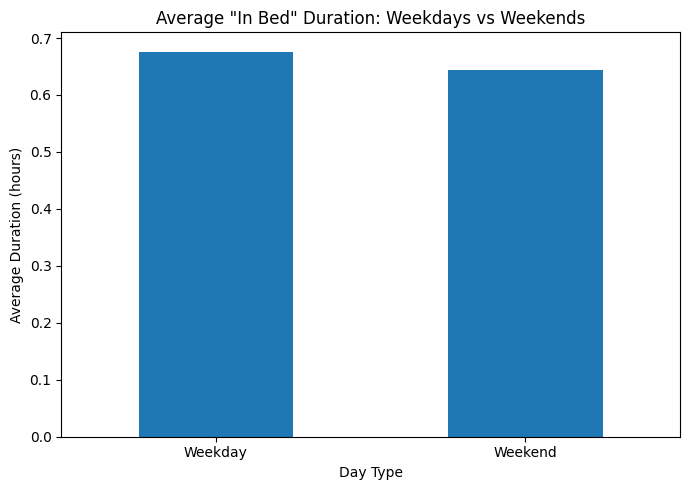

In [ ]:
plt.figure(figsize=(7, 5))
weekday_weekend_sleep_duration.plot(kind='bar')
plt.title('Average "In Bed" Duration: Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Average Duration (hours)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Filter for Deep and REM sleep stages
deep_rem_sleep_df = apple_watch_sleep_df[
    apple_watch_sleep_df['value'].isin(['HKCategoryValueSleepAnalysisAsleepDeep', 'HKCategoryValueSleepAnalysisAsleepREM'])
].copy()

# Extract the time component of the start time
deep_rem_sleep_df['start_time'] = deep_rem_sleep_df['startDate'].dt.time

# Display the first few rows with the new time column
display(deep_rem_sleep_df.head())

,type,sourceName,creationDate,startDate,endDate,value,duration,duration_hour,year_month,month,season,start_time
1014676,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 00:27:28-04:00,2024-02-17 00:45:28-04:00,HKCategoryValueSleepAnalysisAsleepDeep,18.0,0.300000,2024-02,2,Winter,00:27:28
1014683,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 01:33:28-04:00,2024-02-17 01:38:28-04:00,HKCategoryValueSleepAnalysisAsleepDeep,5.0,0.083333,2024-02,2,Winter,01:33:28
1014685,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 02:11:58-04:00,2024-02-17 02:35:28-04:00,HKCategoryValueSleepAnalysisAsleepREM,23.5,0.391667,2024-02,2,Winter,02:11:58
1014695,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 03:43:28-04:00,2024-02-17 03:49:28-04:00,HKCategoryValueSleepAnalysisAsleepREM,6.0,0.100000,2024-02,2,Winter,03:43:28
1014699,HKCategoryTypeIdentifierSleepAnalysis,Ellen’s Apple Watch,2024-02-17 09:54:36 -0400,2024-02-17 03:54:58-04:00,2024-02-17 04:12:58-04:00,HKCategoryValueSleepAnalysisAsleepREM,18.0,0.300000,2024-02,2,Winter,03:54:58


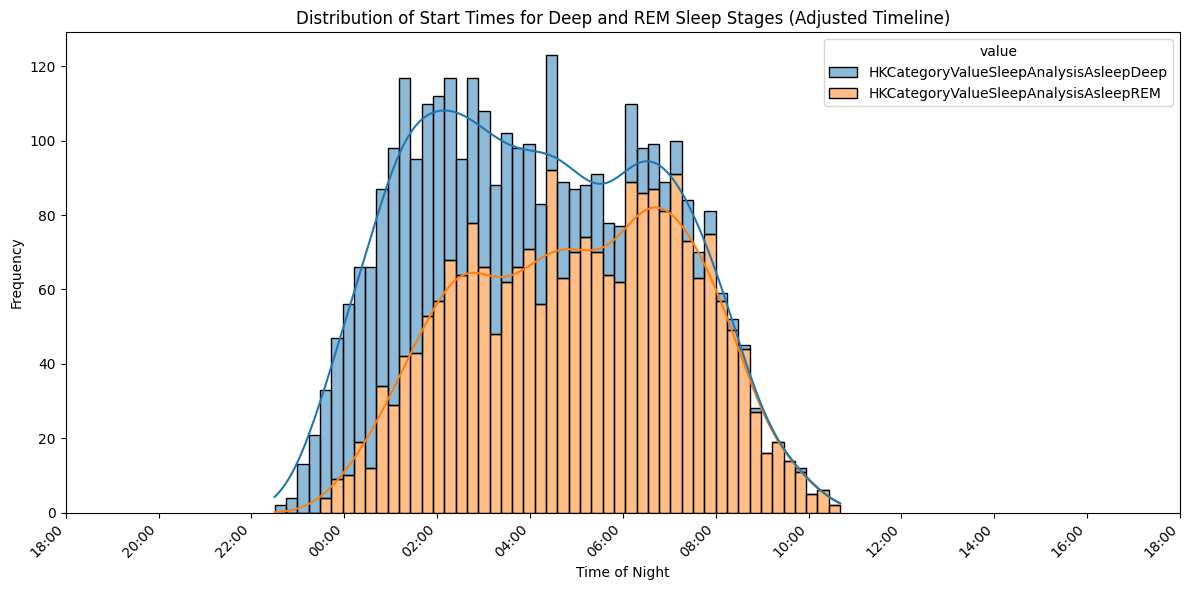

In [ ]:
# Ensure 'start_time' column is created by extracting time from startDate
deep_rem_sleep_df['start_time'] = deep_rem_sleep_df['startDate'].dt.time

# Convert time objects to seconds since midnight for plotting
deep_rem_sleep_df['start_time_seconds'] = deep_rem_sleep_df['start_time'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# Adjust times to represent a timeline spanning across midnight
# Using the same start_of_night_seconds as the bedtime plot for consistency
start_of_night_seconds = 18 * 3600
deep_rem_sleep_df['start_time_seconds_shifted'] = (deep_rem_sleep_df['start_time_seconds'] - start_of_night_seconds) % (24 * 3600)


plt.figure(figsize=(12, 6))
sns.histplot(data=deep_rem_sleep_df, x='start_time_seconds_shifted', hue='value', multiple='stack', bins=50, kde=True)

# Improve x-axis labels by converting shifted seconds back to a time format
# Use the same tick locations and labels as the adjusted bedtime plot for consistency
max_shifted_seconds = deep_rem_sleep_df['start_time_seconds_shifted'].max()
tick_interval_seconds = 2 * 3600
tick_locations_shifted = np.arange(0, 24 * 3600 + tick_interval_seconds, tick_interval_seconds)
tick_labels_shifted = [f'{int(((s + start_of_night_seconds) % (24 * 3600)) // 3600):02d}:{((s + start_of_night_seconds) % 3600) // 60:02d}' for s in tick_locations_shifted]

plt.xticks(tick_locations_shifted, tick_labels_shifted, rotation=45, ha='right')

plt.title('Distribution of Start Times for Deep and REM Sleep Stages (Adjusted Timeline)')
plt.xlabel('Time of Night')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

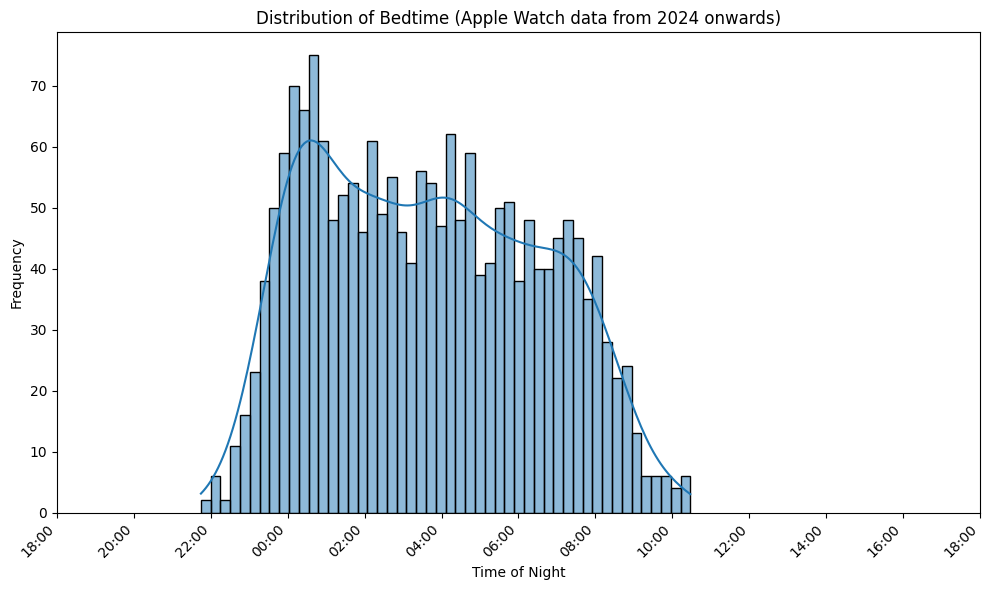

In [ ]:
# Convert bedtime to seconds since midnight for plotting
in_bed_df['bedtime_seconds'] = in_bed_df['bedtime'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# Adjust times that are after midnight by adding 24 hours worth of seconds
# This makes the timeline flow from evening into the next morning
in_bed_df['bedtime_seconds_adjusted'] = in_bed_df['bedtime_seconds'].apply(lambda x: x if x < 12 * 3600 else x - 24 * 3600)
# A better approach is to shift the entire timeline so that midnight is not at the beginning or end.
# Let's set the start of our "night" at, say, 6 PM (18:00)
start_of_night_seconds = 18 * 3600
in_bed_df['bedtime_seconds_shifted'] = (in_bed_df['bedtime_seconds'] - start_of_night_seconds) % (24 * 3600)


plt.figure(figsize=(10, 6))
sns.histplot(data=in_bed_df, x='bedtime_seconds_shifted', bins=50, kde=True)

# Improve x-axis labels by converting shifted seconds back to a time format
max_shifted_seconds = in_bed_df['bedtime_seconds_shifted'].max()
# Generate tick locations at reasonable intervals (e.g., every 2 hours)
# The tick locations should be based on the shifted time scale
tick_interval_seconds = 2 * 3600
# Start ticks from the beginning of the shifted timeline or a bit before, up to the end
tick_locations_shifted = np.arange(0, 24 * 3600 + tick_interval_seconds, tick_interval_seconds)

# Generate corresponding time labels, converting shifted seconds back to standard time
# We need to add the start_of_night_seconds back and take modulo 24 hours to get the correct time
tick_labels_shifted = [f'{int(((s + start_of_night_seconds) % (24 * 3600)) // 3600):02d}:{((s + start_of_night_seconds) % 3600) // 60:02d}' for s in tick_locations_shifted]


plt.xticks(tick_locations_shifted, tick_labels_shifted, rotation=45, ha='right')

plt.title('Distribution of Bedtime (Apple Watch data from 2024 onwards)')
plt.xlabel('Time of Night')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Display the unique values in the 'type' column of the original df
display(df['type'].unique())

array(['HKQuantityTypeIdentifierHeight',
       'HKQuantityTypeIdentifierBodyMass',
       'HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierOxygenSaturation',
       'HKQuantityTypeIdentifierRespiratoryRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierDietaryFatTotal',
       'HKQuantityTypeIdentifierDietaryCarbohydrates',
       'HKQuantityTypeIdentifierDietaryEnergyConsumed',
       'HKQuantityTypeIdentifierDietaryProtein',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierDistanceSwimming',
       'HKQuantityTypeIdentifierRestingHeartRate',
       'HKQuantityTypeIdentifierVO2Max',
       'HKQuantityTypeIdentifierWalkingHeartRateAverage',
       'HKQuantityTypeIdentifierEnvironmentalAudioExp

In [ ]:
# Combine all the daily aggregated data into a single DataFrame
combined_daily_data_expanded = pd.DataFrame({
    'sleep_duration_hours': daily_sleep_summary_excluding_inbed,
    'avg_heart_rate': daily_avg_heart_rate,
    'total_step_count': daily_total_step_count,
    'total_active_energy': daily_total_active_energy,
    'avg_resting_heart_rate': daily_avg_resting_heart_rate,
    'avg_hrv_sdnn': daily_avg_hrv_sdnn
})

# Drop rows with any missing values that resulted from the merge (dates where not all data types are available)
combined_daily_data_expanded.dropna(inplace=True)

display(combined_daily_data_expanded.head())
display(combined_daily_data_expanded.info())

,sleep_duration_hours,avg_heart_rate,total_step_count,total_active_energy,avg_resting_heart_rate,avg_hrv_sdnn
startDate,,,,,,
2024-02-17,9.708333,59.887125,4294,215.824,46.0,81.465183
2024-02-18,7.375000,73.351100,8108,400.934,53.0,71.243300
2024-02-19,8.591667,61.404393,2969,227.163,51.0,77.171533
2024-02-20,8.725000,80.851276,17412,652.630,57.0,62.775667
2024-02-21,8.291667,81.398386,10088,528.880,55.0,61.592080


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 386 entries, 2024-02-17 to 2025-08-03
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sleep_duration_hours    386 non-null    float64
 1   avg_heart_rate          386 non-null    float64
 2   total_step_count        386 non-null    int64  
 3   total_active_energy     386 non-null    float64
 4   avg_resting_heart_rate  386 non-null    float64
 5   avg_hrv_sdnn            386 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 21.1 KB


None

In [ ]:
# Calculate the correlation matrix for the expanded data
correlation_matrix_expanded = combined_daily_data_expanded.corr()

display(correlation_matrix_expanded)

,sleep_duration_hours,avg_heart_rate,total_step_count,total_active_energy,avg_resting_heart_rate,avg_hrv_sdnn
sleep_duration_hours,1.000000,0.033144,0.065010,0.031673,0.074090,0.126964
avg_heart_rate,0.033144,1.000000,0.640852,0.617654,0.188725,-0.150420
total_step_count,0.065010,0.640852,1.000000,0.756550,0.025042,0.080083
total_active_energy,0.031673,0.617654,0.756550,1.000000,-0.075135,0.159267
avg_resting_heart_rate,0.074090,0.188725,0.025042,-0.075135,1.000000,-0.411755
avg_hrv_sdnn,0.126964,-0.150420,0.080083,0.159267,-0.411755,1.000000


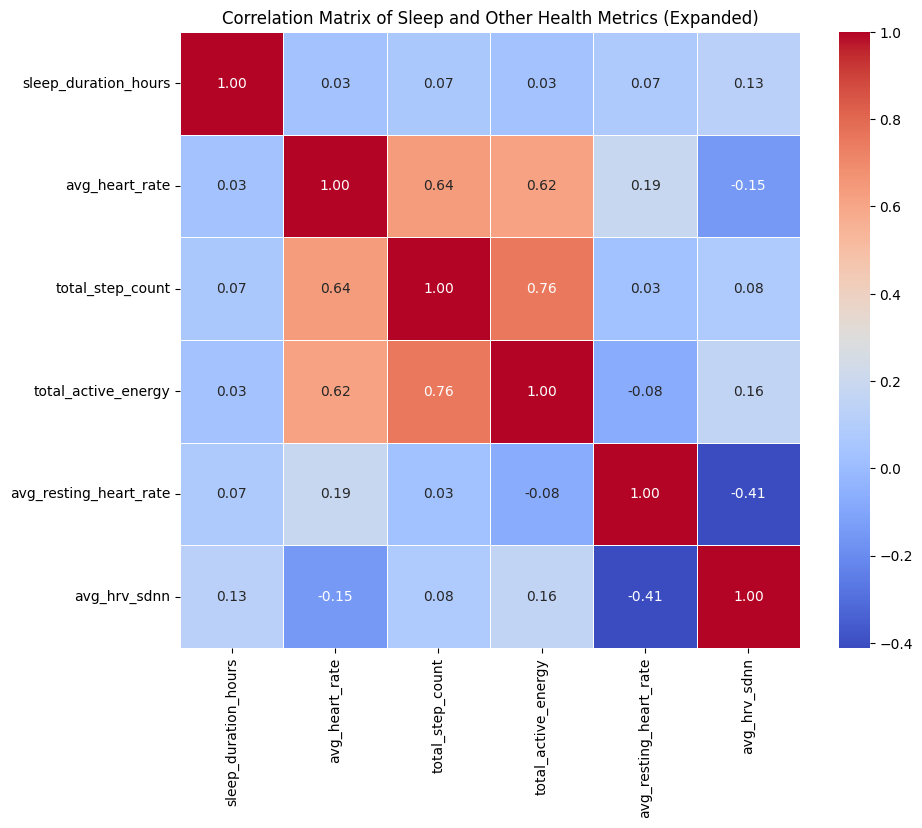

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_expanded, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sleep and Other Health Metrics (Expanded)')
plt.show()

## 5. Summary of Findings

Based on the exploratory data analysis of my Apple Watch sleep data from 2024 onwards, here is a summary of the key findings:

*   **Sleep Stage Distribution:** The analysis of my sleep stage counts and average durations shows the proportion of time I spent in different sleep stages (Core, REM, Deep, Awake, In Bed). I observed the average duration for each stage, with 'In Bed' having the longest average duration, followed by Core, REM, Deep, and Awake.
*   **Daily Sleep Duration:** Visualizing my daily total sleep duration (excluding 'In Bed') revealed the overall trend and variability in my sleep time from night to night.
*   **Outlier Detection:** The box plot and histogram of my daily sleep duration helped in understanding the distribution of my sleep times and identifying potential outliers, which represent unusually short or long sleep nights for me.
*   **Monthly and Seasonal Patterns:** Analyzing the monthly average duration of my sleep stages and comparing my sleep patterns between summer and winter provided insights into potential seasonal influences on my sleep.
*   **Sleep Consistency:** Visualizing the distribution of my bedtime with an adjusted timeline showed the consistency of my sleep starting times.
*   **Timing of Sleep Stages:** The adjusted timeline histograms for Deep and REM sleep start times illustrated when these crucial sleep stages typically began during my sleep sessions.
*   **Correlations with Other Factors:** The expanded correlation heatmap showed the linear relationships between my daily sleep duration and other health metrics like my average heart rate, total step count, total active energy burned, average resting heart rate, and average HRV SDNN. I observed relatively weak linear correlations between my sleep duration and these activity/physiological metrics in this dataset.

These findings provide a good foundation for understanding my sleep patterns and how they relate to other aspects of my health data. Further analysis could delve deeper into specific periods, investigate the identified outliers, or explore non-linear relationships between the factors.